In [180]:
import pandas as pd
import numpy as np
import re
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.cluster import SpectralClustering
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import completeness_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
 
from sklearn.model_selection import GridSearchCV
from pprint import pprint

from scipy.stats import pearsonr
from statistics import mean 
from scipy.spatial.distance import pdist
import math

from collections import Counter

import matplotlib.pyplot as plt
% matplotlib inline

## Load evaluation

In [530]:
projects = pd.read_csv('projects.csv', names=['repoId', ' ', 'repo'])
projects.drop(columns=[' '], inplace=True)
#projects = projects[projects['repo'].isin(sub_data['repo'])]
project_clone = pd.read_csv('project_clones.0.csv')
project_clone.columns = ['cloneId', 'cloneClonedFiles', 'cloneTotalFiles', 'cloneClonedPercent', \
                        'hostId', 'hostAffectedFiles', 'hostTotalFiles', 'hostAffectedPercent']

def loadRepoNames():
    RepoNames = {}
    for index, field in projects.iterrows():
        RepoNames[int(field['repoId'])] = field['repo']
    return RepoNames
nameDict = loadRepoNames()
def simBetwRepos(cloneTotalFiles, ClonedPercent, hostTotalFiles, hostAffectedPercent):
    similarity = (cloneTotalFiles * ClonedPercent * 0.01 + hostTotalFiles * hostAffectedPercent * 0.01) \
    / (cloneTotalFiles + hostTotalFiles)
    return similarity
project_clone['sim'] = project_clone.apply(lambda x: \
                                           simBetwRepos(x['cloneTotalFiles'], x['cloneClonedPercent'], \
                                                       x['hostTotalFiles'], x['hostAffectedPercent']), axis=1)
clone = project_clone[['cloneId', 'hostId', 'sim']]
clone.columns = ['repo1', 'repo2', 'sim']
host = project_clone[['hostId', 'cloneId', 'sim']]
host.columns = ['repo1', 'repo2', 'sim']
clone_host = clone.append(host)

simMatrix = clone_host.pivot_table(index='repo1', columns='repo2', values='sim').fillna(0)
#.sort_index(inplace=True)
#
np.fill_diagonal(simMatrix.values, 1)


In [490]:
dm = (1 - simMatrix.values)
n = dm.shape[0]
DM = dm[np.triu_indices(n,1)]
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, fcluster, cophenet
import scipy.cluster.hierarchy

## Grid Search for the number of clusters w.r.t silhouette score

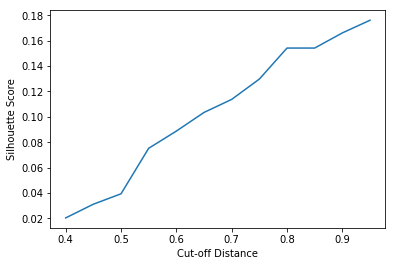

In [55]:
cut_off = [i for i in np.arange(0.4, 1, 0.05)]
silhouette = {}
for co in cut_off:
    nodes = fcluster(z, co, criterion='distance')
    silhouette[co] = silhouette_score(dm, nodes, metric='correlation')
plt.figure()
plt.plot(list(silhouette.keys()), list(silhouette.values()))
plt.xlabel("Cut-off Distance")
plt.ylabel("Silhouette Score")
plt.show()

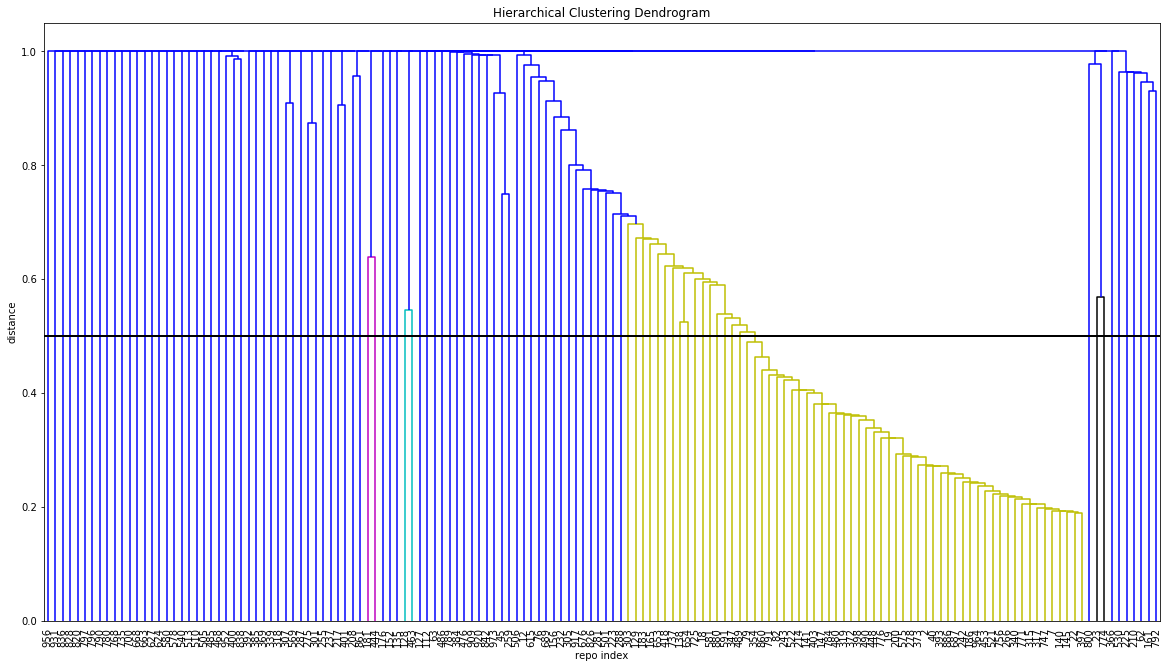

In [491]:
plt.figure(figsize=(20, 11))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('repo index')
plt.ylabel('distance')
#labelList = range(1, 9)
z = linkage(DM)
dendrogram(
    z,
   # truncate_mode='lastp',
    leaf_font_size=10.,  # font size for the x axis labels
    labels=simMatrix.index,
    show_contracted=True
)
plt.axhline(y=.5, xmin=0, xmax=4, linewidth=2, color = 'k')
#plt.axhline()
plt.show()

In [487]:
len(set(fcluster(z, 0.5, criterion='distance')))

105

In [492]:
eval_table = pd.DataFrame({'repoId': simMatrix.index, 'label': fcluster(z, 0.5, criterion='distance')})
eval_table = eval_table.merge(projects, on='repoId')[['repoId', 'repo', 'label']]

## Load cleaned Data

In [486]:
#sub_data = pd.read_csv('stemmed_data.csv')
tn_data = sub_data[['repo', 'stemmed_name', 'tn_length', 'tn_difflen']]

In [326]:
sub_data = sub_data.fillna(' ')
sub_data = sub_data.drop_duplicates(subset=['repo'], keep='first').reset_index()

In [478]:
tn_data['tn_difflen'].describe()

count    1769.000000
mean     1116.970605
std      1357.940917
min        47.000000
25%       299.000000
50%       642.000000
75%      1364.000000
max      9952.000000
Name: tn_difflen, dtype: float64

In [430]:
sample = pd.read_csv('sample.csv')

In [432]:
sample.columns

Index(['repo', 'token.name', 'token.comment', 'tag', 'stemmed_name',
       'stemmed_comment', 'tn_length', 'tc_length', 'tn_difflen',
       'tc_difflen'],
      dtype='object')

In [439]:
sub_data = sub_data.append(sample[['repo', 'token.name', 'token.comment', 'tn_length', 'tc_length',
       'tn_difflen', 'tc_difflen', 'stemmed_name', 'stemmed_comment']]).drop_duplicates(subset=['repo'], keep='first').reset_index()

In [443]:
tn_data.shape

(1785, 4)

## hash embeddings

In [6]:
def hash2vec(doc, length):
    doc = doc.split(' ')
    doc = Counter(doc)
    embedding = [0] * length
    for word in doc:
        hval = hash(word) % length
        embedding[hval] += doc[word]
    return np.array(embedding)

def vectorize(column):
    '''Transfer a column of dataframe into np.array'''
    fit_vec = np.array(column[0])
    for field in column:
        fit_vec = np.vstack((fit_vec, field))
    fit_vec = np.delete(fit_vec, 0, 0)
    return fit_vec

def pearson_dist(matrix):
    '''Calculate distance matrix using pearson correlation'''
    n, m = matrix.shape
    value = pdist(matrix, 'correlation')
    start = 0
    pearson_affinity = np.zeros((n, n))
    for i in range(n - 1):
        for j in range(i + 1, n):
            pearson_affinity[i, j] = value[start + j - 1]
            pearson_affinity[j, i] = value[start + j - 1]
        start += n - i - 2
    return pearson_affinity

In [188]:
def is_prime(num):
    """Returns True if the number is prime
    else False."""
    if num == 0 or num == 1:
        return False
    for x in range(2, num):
        if num % x == 0:
            return False
    else:
        return True
buckets_length = []
for i in filter(is_prime, range(500, 1500, 23)):
    buckets_length.append(i)

In [191]:
sse = {}
for b_len in buckets_length:
    tn_data['hash2vec'] = tn_data['stemmed_name'].apply(lambda x: hash2vec(x, b_len))
    print("Hashing finished...")
    name_fit = vectorize(tn_data['hash2vec'])
    print('vectorization finished...')
    sse_b = {}
    key = 'bucket' + str(b_len)
    for k in range(100, 520, 40):
        kmeans = KMeans(n_clusters=k, max_iter=200, random_state=122).fit(name_fit)
        #data["clusters"] = kmeans.labels_
        #print(data["clusters"])
        sse_b[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
        print("Finished calculating k = " + str(k) + " for bucket length = " + str(b_len))
    sse[key] = sse_b
#plt.figure()
#plt.plot(list(sse.keys()), list(sse.values()))
#plt.xlabel("Number of cluster")
#plt.ylabel("SSE")
#plt.show()

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 523
Finished calculating k = 140 for bucket length = 523
Finished calculating k = 180 for bucket length = 523
Finished calculating k = 220 for bucket length = 523
Finished calculating k = 260 for bucket length = 523
Finished calculating k = 300 for bucket length = 523
Finished calculating k = 340 for bucket length = 523
Finished calculating k = 380 for bucket length = 523
Finished calculating k = 420 for bucket length = 523
Finished calculating k = 460 for bucket length = 523
Finished calculating k = 500 for bucket length = 523


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 569
Finished calculating k = 140 for bucket length = 569
Finished calculating k = 180 for bucket length = 569
Finished calculating k = 220 for bucket length = 569
Finished calculating k = 260 for bucket length = 569
Finished calculating k = 300 for bucket length = 569
Finished calculating k = 340 for bucket length = 569
Finished calculating k = 380 for bucket length = 569
Finished calculating k = 420 for bucket length = 569
Finished calculating k = 460 for bucket length = 569
Finished calculating k = 500 for bucket length = 569


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 661
Finished calculating k = 140 for bucket length = 661
Finished calculating k = 180 for bucket length = 661
Finished calculating k = 220 for bucket length = 661
Finished calculating k = 260 for bucket length = 661
Finished calculating k = 300 for bucket length = 661
Finished calculating k = 340 for bucket length = 661
Finished calculating k = 380 for bucket length = 661
Finished calculating k = 420 for bucket length = 661
Finished calculating k = 460 for bucket length = 661
Finished calculating k = 500 for bucket length = 661


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 937
Finished calculating k = 140 for bucket length = 937
Finished calculating k = 180 for bucket length = 937
Finished calculating k = 220 for bucket length = 937
Finished calculating k = 260 for bucket length = 937
Finished calculating k = 300 for bucket length = 937
Finished calculating k = 340 for bucket length = 937
Finished calculating k = 380 for bucket length = 937
Finished calculating k = 420 for bucket length = 937
Finished calculating k = 460 for bucket length = 937
Finished calculating k = 500 for bucket length = 937


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 983
Finished calculating k = 140 for bucket length = 983
Finished calculating k = 180 for bucket length = 983
Finished calculating k = 220 for bucket length = 983
Finished calculating k = 260 for bucket length = 983
Finished calculating k = 300 for bucket length = 983
Finished calculating k = 340 for bucket length = 983
Finished calculating k = 380 for bucket length = 983
Finished calculating k = 420 for bucket length = 983
Finished calculating k = 460 for bucket length = 983
Finished calculating k = 500 for bucket length = 983


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 1213
Finished calculating k = 140 for bucket length = 1213
Finished calculating k = 180 for bucket length = 1213
Finished calculating k = 220 for bucket length = 1213
Finished calculating k = 260 for bucket length = 1213
Finished calculating k = 300 for bucket length = 1213
Finished calculating k = 340 for bucket length = 1213
Finished calculating k = 380 for bucket length = 1213
Finished calculating k = 420 for bucket length = 1213
Finished calculating k = 460 for bucket length = 1213
Finished calculating k = 500 for bucket length = 1213


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 1259
Finished calculating k = 140 for bucket length = 1259
Finished calculating k = 180 for bucket length = 1259
Finished calculating k = 220 for bucket length = 1259
Finished calculating k = 260 for bucket length = 1259
Finished calculating k = 300 for bucket length = 1259
Finished calculating k = 340 for bucket length = 1259
Finished calculating k = 380 for bucket length = 1259
Finished calculating k = 420 for bucket length = 1259
Finished calculating k = 460 for bucket length = 1259
Finished calculating k = 500 for bucket length = 1259


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 1489
Finished calculating k = 140 for bucket length = 1489
Finished calculating k = 180 for bucket length = 1489
Finished calculating k = 220 for bucket length = 1489
Finished calculating k = 260 for bucket length = 1489
Finished calculating k = 300 for bucket length = 1489
Finished calculating k = 340 for bucket length = 1489
Finished calculating k = 380 for bucket length = 1489
Finished calculating k = 420 for bucket length = 1489
Finished calculating k = 460 for bucket length = 1489
Finished calculating k = 500 for bucket length = 1489


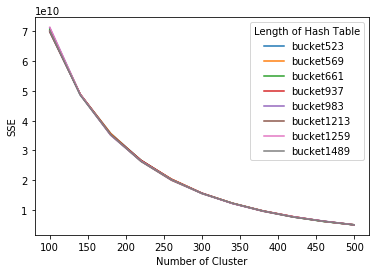

In [192]:
plt.figure()
n_cluster = [i for i in range(100, 520, 40)]
for n_bucket, record in sse.items():
    plt.plot(n_cluster, list(record.values()), label=str(n_bucket))
plt.xlabel("Number of Cluster")
plt.ylabel("SSE")
plt.legend(title='Length of Hash Table', loc='best')
plt.show()

In [506]:
tn_data['hash2vec'] = tn_data['stemmed_name'].apply(lambda x: hash2vec(x, 523))
name_fit = vectorize(tn_data['hash2vec'])

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [494]:
testset = tn_data[tn_data['repo'].isin(eval_table['repo'])]
test_fit = vectorize(testset['hash2vec'])
trainset = tn_data[~tn_data['repo'].isin(eval_table['repo'])].reset_index()
train_fit = vectorize(trainset['hash2vec'])


## AgglomerativeClustering

In [495]:
#cluster_ac = AgglomerativeClustering(n_clusters=200, linkage='average',
#                           affinity=pearson_dist)
#cluster_ac.fit(name_fit)
Z = linkage(name_fit, metric = 'correlation')


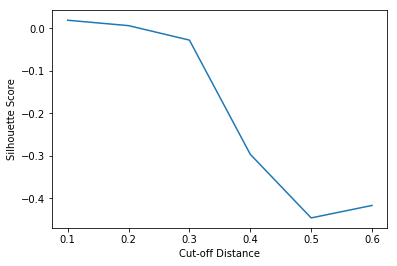

In [334]:
cut_off = [i for i in np.arange(0.1, 0.7, 0.1)]
silhouette = {}
dm = pearson_dist(name_fit)
for co in cut_off:
    nodes = fcluster(Z, co, criterion='distance')
    silhouette[co] = silhouette_score(dm, nodes, metric='correlation')
plt.figure()
plt.plot(list(silhouette.keys()), list(silhouette.values()))
plt.xlabel("Cut-off Distance")
plt.ylabel("Silhouette Score")
plt.show()

In [335]:
nodes = fcluster(Z, 0.32, criterion='distance')
silhouette_score(dm, nodes, metric='euclidean')

-0.04704076463793034

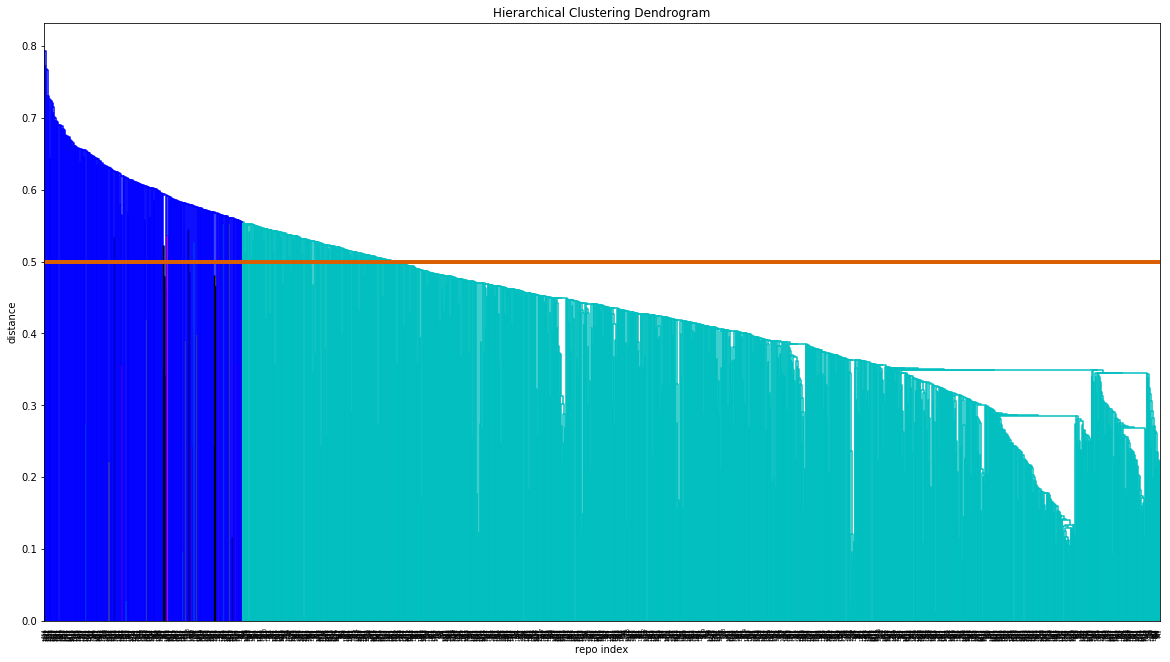

In [484]:
scipy.cluster.hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
plt.figure(figsize=(20, 11))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('repo index')
plt.ylabel('distance')

dendrogram(
    Z,
    #truncate_mode='lastp',
   # leaf_font_size=10.,  # font size for the x axis labels
   # labels=,
    show_contracted=True,
    orientation='top'
   # above_threshold_color='y'
)
plt.axhline(y=.5, xmin=0, xmax=4, linewidth=4, color = '#d95f02')
#plt.axhline()
plt.show()

In [499]:
hac_data = tn_data
hac_data['pred_label'] = fcluster(Z, 0.6, criterion='distance')
test_hac = hac_data[hac_data['repo'].isin(eval_table['repo'])]

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [497]:
len(set(hac_data['pred_label']))

1372

In [500]:
eval_ac = eval_table[['repo', 'label']].merge(test_hac[['repo', 'pred_label']], on='repo').drop_duplicates()
h_score = homogeneity_score(eval_ac['label'], eval_ac['pred_label'])
completeness = completeness_score(eval_ac['label'], eval_ac['pred_label'])
print("Homogeneity: %0.3f" % h_score)
print("Completeness: %0.3f" % completeness)
Recall = []
Precision = []
for name, group in eval_ac.groupby('label'):
    if group.shape[0] > 1:
        purity = Counter(group['pred_label']).most_common()[0][1]
        recall = purity / group.shape[0]
        Recall.append(recall)
print('Recall is %.2f' %(sum(Recall)/len(Recall)))
for name, group in eval_ac.groupby('pred_label'):
    if group.shape[0] > 1:
        purity = Counter(group['label']).most_common()[0][1]
        precision = purity / group.shape[0]
        Precision.append(precision)
print('Precision is %.2f' %(sum(Precision)/len(Precision)))
      


Homogeneity: 0.061
Completeness: 0.653
Recall is 0.93
Precision is 0.33


In [344]:
pca = PCA(n_components=2)
pca_res = pca.fit_transform(name_fit)
x = pca_res[:, 0]
y = pca_res[:, 1]
print("Explained variance ratio: ", pca.explained_variance_ratio_)

Explained variance ratio:  [0.33594388 0.09080327]


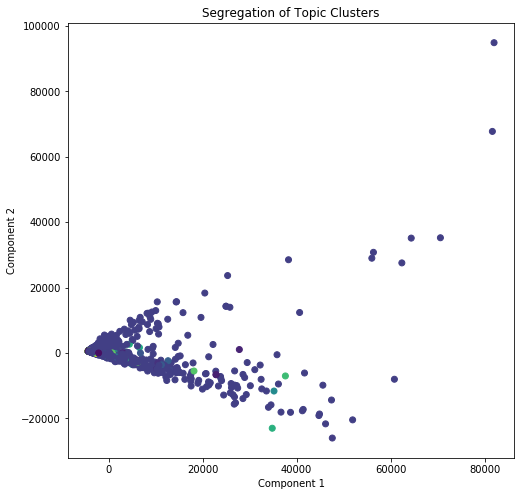

In [345]:
# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=hac_data['pred_label'])
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

## KMeans

Finished calculating k = 50
Finished calculating k = 100
Finished calculating k = 150
Finished calculating k = 200
Finished calculating k = 250
Finished calculating k = 300
Finished calculating k = 350
Finished calculating k = 400
Finished calculating k = 450
Finished calculating k = 500
Finished calculating k = 550
Finished calculating k = 600
Finished calculating k = 650
Finished calculating k = 700
Finished calculating k = 750
Finished calculating k = 800
Finished calculating k = 850
Finished calculating k = 900
Finished calculating k = 950


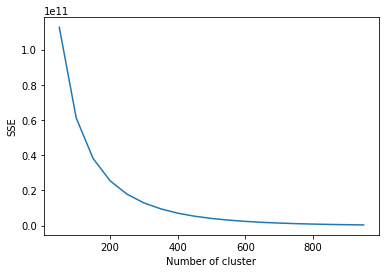

In [572]:
sse = {}
for k in range(50, 1000, 50):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(name_fit)
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    print("Finished calculating k = " + str(k))
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


In [102]:
kmeans.fit_predict(test_fit)

100

In [510]:
kmeans_pearson = 1 - pearson_dist(name_fit)

In [512]:
kmeans_data = tn_data
kmeans = KMeans(n_clusters=150, random_state=122, precompute_distances=True).fit(kmeans_pearson)
kmeans_data['pred_label'] = kmeans.labels_
kmeans_test = kmeans_data[kmeans_data['repo'].isin(eval_table['repo'])]

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [545]:
kmeans_eval = eval_table[eval_table['repo'].isin(kmeans_test['repo'])]

In [546]:
kmeans_eval = kmeans_eval.merge(tn_data[['repo', 'stemmed_name']], on='repo').drop_duplicates(subset=['repo'])

In [547]:
kmeans_eval['hash2vec'] = kmeans_eval['stemmed_name'].apply(lambda x: hash2vec(x, 523))
test_fit = vectorize(kmeans_eval['hash2vec'])

In [513]:
#test_kmeans = testset
#kmeans_test = KMeans(n_clusters=77, max_iter=1000).fit(test_fit)
#test_kmeans['pred_label'] = kmeans_test.labels_

eval_kmeans = eval_table[['repo', 'label']].merge(kmeans_test[['repo', 'pred_label']], on='repo').drop_duplicates()
h_score = homogeneity_score(eval_kmeans['label'], eval_kmeans['pred_label'])
completeness = completeness_score(eval_kmeans['label'], eval_kmeans['pred_label'])
print("Homogeneity: %0.3f" % h_score)
print("Completeness: %0.3f" % completeness)
Recall = []
Precision = []
for name, group in eval_kmeans.groupby('label'):
    if group.shape[0] > 1:
        purity = Counter(group['pred_label']).most_common()[0][1]
        recall = purity / group.shape[0]
        Recall.append(recall)
print('Recall is %.2f' %(sum(Recall)/len(Recall)))
for name, group in eval_kmeans.groupby('pred_label'):
    if group.shape[0] > 1:
        purity = Counter(group['label']).most_common()[0][1]
        precision = purity / group.shape[0]
        Precision.append(precision)
print('Precision is %.2f' %(sum(Precision)/len(Precision)))
      

Homogeneity: 0.864
Completeness: 0.731
Recall is 0.07
Precision is 0.55


In [349]:
test_kmeans = testset
kmeans_test = KMeans(n_clusters=77, max_iter=1000).fit(test_fit)
test_kmeans['pred_label'] = kmeans_test.labels_

eval_kmeans = eval_table[['repo', 'label']].merge(test_kmeans[['repo', 'pred_label']], on='repo').drop_duplicates()
h_score = homogeneity_score(eval_kmeans['label'], eval_kmeans['pred_label'])
completeness = completeness_score(eval_kmeans['label'], eval_kmeans['pred_label'])
print("Homogeneity: %0.3f" % h_score)
print("Completeness: %0.3f" % completeness)
Recall = []
Precision = []
for name, group in eval_kmeans.groupby('label'):
    if group.shape[0] > 1:
        purity = Counter(group['pred_label']).most_common()[0][1]
        recall = purity / group.shape[0]
        Recall.append(recall)
print('Recall is %.2f' %(sum(Recall)/len(Recall)))
for name, group in eval_kmeans.groupby('pred_label'):
    if group.shape[0] > 1:
        purity = Counter(group['label']).most_common()[0][1]
        precision = purity / group.shape[0]
        Precision.append(precision)
print('Precision is %.2f' %(sum(Precision)/len(Precision)))

Homogeneity: 0.739
Completeness: 0.543
Recall is 0.42
Precision is 0.59


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


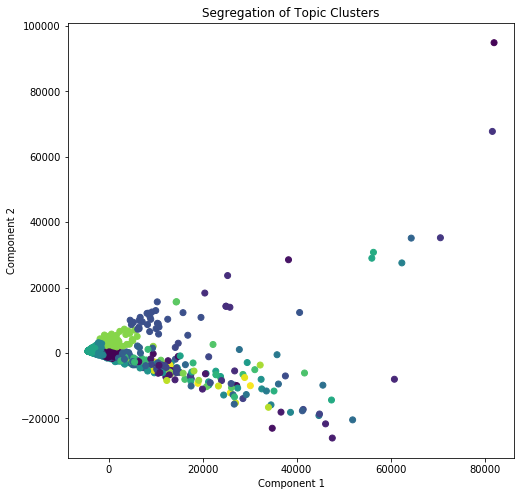

In [350]:
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=kmeans_data['pred_label'])
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [557]:
with open('label', 'r') as f:
    lda_label = [i.split('\n')[0] for i in f.readlines()] 

In [564]:
lda_label = pd.read_csv('label', header=None, names=['lda_label'])

In [569]:
homogeneity_score(kmeans_data['pred_label'], lda_label['lda_label'] )

0.6098520692057462

In [571]:
completeness_score(kmeans_data['pred_label'], lda_label['lda_label'])

0.5747475927160394

## Normalize

In [514]:
name_fit_norm = normalize(name_fit, axis=1, norm='l2')

In [352]:
buckets_length = []
for i in filter(is_prime, range(500, 1500, 23)):
    buckets_length.append(i)

In [353]:
buckets_length

[523, 569, 661, 937, 983, 1213, 1259, 1489]

In [186]:
sse = {}
for b_len in buckets_length:
    tn_data['hash2vec'] = tn_data['stemmed_name'].apply(lambda x: hash2vec(x, b_len))
    print("Hashing finished...")
    name_fit = vectorize(tn_data['hash2vec'])
    name_fit_norm = normalize(name_fit, axis=1, norm='l2')
    print('vectorization finished...')
    sse_b = {}
    key = 'bucket' + str(b_len)
    for k in range(100, 400, 40):
        kmeans = KMeans(n_clusters=k, random_state=122, max_iter=200).fit(name_fit_norm)
        #data["clusters"] = kmeans.labels_
        #print(data["clusters"])
        sse_b[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
        print("Finished calculating k = " + str(k) + " for bucket length = " + str(b_len))
    sse[key] = sse_b
#plt.figure()
#plt.plot(list(sse.keys()), list(sse.values()))
#plt.xlabel("Number of cluster")
#plt.ylabel("SSE")
#plt.show()

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 523
Finished calculating k = 140 for bucket length = 523
Finished calculating k = 180 for bucket length = 523
Finished calculating k = 220 for bucket length = 523
Finished calculating k = 260 for bucket length = 523
Finished calculating k = 300 for bucket length = 523
Finished calculating k = 340 for bucket length = 523
Finished calculating k = 380 for bucket length = 523


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 569
Finished calculating k = 140 for bucket length = 569
Finished calculating k = 180 for bucket length = 569
Finished calculating k = 220 for bucket length = 569
Finished calculating k = 260 for bucket length = 569
Finished calculating k = 300 for bucket length = 569
Finished calculating k = 340 for bucket length = 569
Finished calculating k = 380 for bucket length = 569


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 661
Finished calculating k = 140 for bucket length = 661
Finished calculating k = 180 for bucket length = 661
Finished calculating k = 220 for bucket length = 661
Finished calculating k = 260 for bucket length = 661
Finished calculating k = 300 for bucket length = 661
Finished calculating k = 340 for bucket length = 661
Finished calculating k = 380 for bucket length = 661


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 937
Finished calculating k = 140 for bucket length = 937
Finished calculating k = 180 for bucket length = 937
Finished calculating k = 220 for bucket length = 937
Finished calculating k = 260 for bucket length = 937
Finished calculating k = 300 for bucket length = 937
Finished calculating k = 340 for bucket length = 937
Finished calculating k = 380 for bucket length = 937


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 983
Finished calculating k = 140 for bucket length = 983
Finished calculating k = 180 for bucket length = 983
Finished calculating k = 220 for bucket length = 983
Finished calculating k = 260 for bucket length = 983
Finished calculating k = 300 for bucket length = 983
Finished calculating k = 340 for bucket length = 983
Finished calculating k = 380 for bucket length = 983


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 1213
Finished calculating k = 140 for bucket length = 1213
Finished calculating k = 180 for bucket length = 1213
Finished calculating k = 220 for bucket length = 1213
Finished calculating k = 260 for bucket length = 1213
Finished calculating k = 300 for bucket length = 1213
Finished calculating k = 340 for bucket length = 1213
Finished calculating k = 380 for bucket length = 1213


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 1259
Finished calculating k = 140 for bucket length = 1259
Finished calculating k = 180 for bucket length = 1259
Finished calculating k = 220 for bucket length = 1259
Finished calculating k = 260 for bucket length = 1259
Finished calculating k = 300 for bucket length = 1259
Finished calculating k = 340 for bucket length = 1259
Finished calculating k = 380 for bucket length = 1259


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 1489
Finished calculating k = 140 for bucket length = 1489
Finished calculating k = 180 for bucket length = 1489
Finished calculating k = 220 for bucket length = 1489
Finished calculating k = 260 for bucket length = 1489
Finished calculating k = 300 for bucket length = 1489
Finished calculating k = 340 for bucket length = 1489
Finished calculating k = 380 for bucket length = 1489


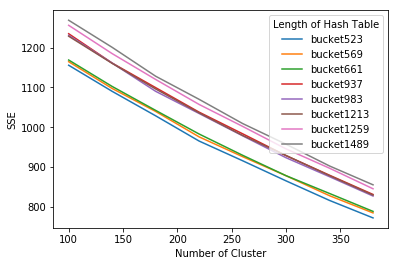

In [187]:
plt.figure()
n_cluster = [i for i in range(100, 400, 40)]
for n_bucket, record in sse.items():
    plt.plot(n_cluster, list(record.values()), label=str(n_bucket))
plt.xlabel("Number of Cluster")
plt.ylabel("SSE")
plt.legend(title='Length of Hash Table', loc='best')
plt.show()

## Hierachy clustering

In [354]:
Z_norm = linkage(name_fit_norm, metric = 'correlation')


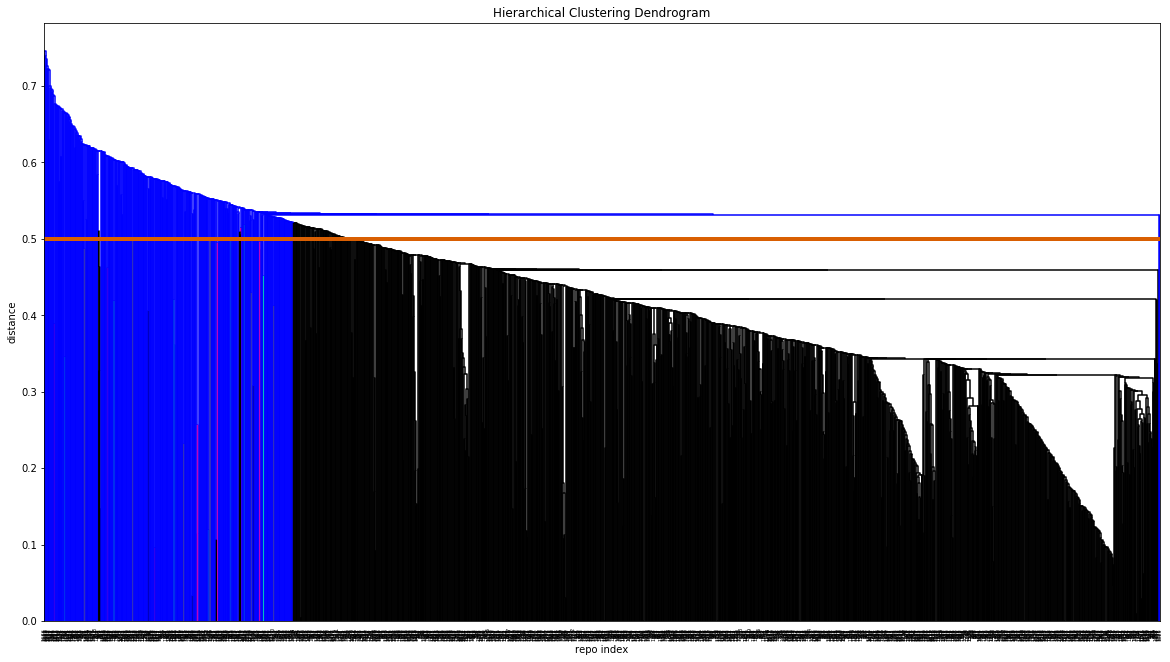

In [355]:
scipy.cluster.hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
plt.figure(figsize=(20, 11))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('repo index')
plt.ylabel('distance')

dendrogram(
    Z_norm,
    #truncate_mode='lastp',
   # leaf_font_size=10.,  # font size for the x axis labels
   # labels=,
    show_contracted=True,
    orientation='top'
   # above_threshold_color='y'
)
plt.axhline(y=.5, xmin=0, xmax=4, linewidth=4, color = '#d95f02')
#plt.axhline()
plt.show()

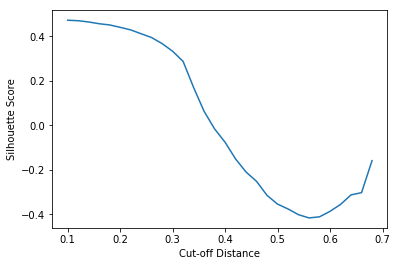

In [241]:
cut_off = [i for i in np.arange(0.1, 0.7, 0.02)]
silhouette = {}
dm = pearson_dist(name_fit_norm)
for co in cut_off:
    nodes = fcluster(Z_norm, co, criterion='distance')
    silhouette[co] = silhouette_score(dm, nodes, metric='correlation')
plt.figure()
plt.plot(list(silhouette.keys()), list(silhouette.values()))
plt.xlabel("Cut-off Distance")
plt.ylabel("Silhouette Score")
plt.show()

In [356]:
hac_data_norm = tn_data
hac_data_norm['pred_label'] = fcluster(Z_norm, 0.3, criterion='distance')
test_hac_norm = hac_data_norm[hac_data_norm['repo'].isin(eval_table['repo'])]
len(set(hac_data_norm['pred_label']))

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1346

In [357]:
eval_ac_norm = eval_table[['repo', 'label']].merge(test_hac_norm[['repo', 'pred_label']], on='repo').drop_duplicates()
h_score = homogeneity_score(eval_ac_norm['label'], eval_ac_norm['pred_label'])
completeness = completeness_score(eval_ac_norm['label'], eval_ac_norm['pred_label'])
print("Homogeneity: %0.3f" % h_score)
print("Completeness: %0.3f" % completeness)
Recall = []
Precision = []
for name, group in eval_ac_norm.groupby('label'):
    if group.shape[0] > 1:
        purity = Counter(group['pred_label']).most_common()[0][1]
        recall = purity / group.shape[0]
        Recall.append(recall)
print('Recall is %.2f' %(sum(Recall)/len(Recall)))
for name, group in eval_ac_norm.groupby('pred_label'):
    if group.shape[0] > 1:
        purity = Counter(group['label']).most_common()[0][1]
        precision = purity / group.shape[0]
        Precision.append(precision)
print('Precision is %.2f' %(sum(Precision)/len(Precision)))
      


Homogeneity: 0.948
Completeness: 0.566
Recall is 0.69
Precision is 0.81


In [358]:
test_hac_norm = testset
Z_test_norm = linkage(normalize(test_fit, axis=1, norm='l2'), metric = 'correlation')
test_hac_norm['pred_label'] = fcluster(Z_test_norm, 0.3, criterion='distance')
eval_ac_norm = eval_table[['repo', 'label']].merge(test_hac_norm[['repo', 'pred_label']], on='repo').drop_duplicates()
h_score = homogeneity_score(eval_ac_norm['label'], eval_ac_norm['pred_label'])
completeness = completeness_score(eval_ac_norm['label'], eval_ac_norm['pred_label'])
print("Homogeneity: %0.3f" % h_score)
print("Completeness: %0.3f" % completeness)
Recall = []
Precision = []
for name, group in eval_ac_norm.groupby('label'):
    if group.shape[0] > 1:
        purity = Counter(group['pred_label']).most_common()[0][1]
        recall = purity / group.shape[0]
        Recall.append(recall)
print('Recall is %.2f' %(sum(Recall)/len(Recall)))
for name, group in eval_ac_norm.groupby('pred_label'):
    if group.shape[0] > 1:
        purity = Counter(group['label']).most_common()[0][1]
        precision = purity / group.shape[0]
        Precision.append(precision)
print('Precision is %.2f' %(sum(Precision)/len(Precision)))
      

Homogeneity: 0.989
Completeness: 0.566
Recall is 0.68
Precision is 0.88


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## KMeans

Finished calculating k = 50
Finished calculating k = 100
Finished calculating k = 150
Finished calculating k = 200
Finished calculating k = 250
Finished calculating k = 300
Finished calculating k = 350
Finished calculating k = 400
Finished calculating k = 450
Finished calculating k = 500
Finished calculating k = 550
Finished calculating k = 600
Finished calculating k = 650
Finished calculating k = 700
Finished calculating k = 750
Finished calculating k = 800
Finished calculating k = 850
Finished calculating k = 900
Finished calculating k = 950


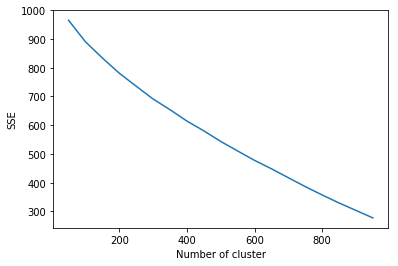

In [362]:
sse = {}
for k in range(50, 1000, 50):
    kmeans_norm = KMeans(n_clusters=k, max_iter=200).fit(name_fit_norm)
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans_norm.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    print("Finished calculating k = " + str(k))
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


In [515]:
kmeans_data_norm = tn_data
kmeans_norm = KMeans(n_clusters=150, random_state=122).fit(name_fit_norm)
kmeans_data_norm['pred_label'] = kmeans_norm.labels_
kmeans_test_norm = kmeans_data_norm[kmeans_data_norm['repo'].isin(eval_table['repo'])]

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [520]:
kmeans_norm.inertia_

836.3866817666603

In [516]:
eval_kmeans_norm = eval_table[['repo', 'label']].merge(kmeans_test_norm[['repo', 'pred_label']], on='repo').drop_duplicates()
h_score = homogeneity_score(eval_kmeans_norm['label'], eval_kmeans_norm['pred_label'])
completeness = completeness_score(eval_kmeans_norm['label'], eval_kmeans_norm['pred_label'])
print("Homogeneity: %0.3f" % h_score)
print("Completeness: %0.3f" % completeness)
Recall = []
Precision = []
for name, group in eval_kmeans_norm.groupby('label'):
    if group.shape[0] > 1:
        purity = Counter(group['pred_label']).most_common()[0][1]
        recall = purity / group.shape[0]
        Recall.append(recall)
print('Recall is %.2f' %(sum(Recall)/len(Recall)))
for name, group in eval_kmeans_norm.groupby('pred_label'):
    if group.shape[0] > 1:
        purity = Counter(group['label']).most_common()[0][1]
        precision = purity / group.shape[0]
        Precision.append(precision)
print('Precision is %.2f' %(sum(Precision)/len(Precision)))
      

Homogeneity: 0.789
Completeness: 0.723
Recall is 0.15
Precision is 0.48


In [369]:
test_kmeans_norm = testset
kmeans_test_norm = KMeans(n_clusters=77, max_iter=1000).fit(normalize(test_fit, axis=1, norm='l2'))
test_kmeans_norm['pred_label'] = kmeans_test_norm.labels_

eval_kmeans_norm = eval_table[['repo', 'label']].merge(test_kmeans_norm[['repo', 'pred_label']], on='repo').drop_duplicates()
h_score = homogeneity_score(eval_kmeans_norm['label'], eval_kmeans_norm['pred_label'])
completeness = completeness_score(eval_kmeans_norm['label'], eval_kmeans_norm['pred_label'])
print("Homogeneity: %0.3f" % h_score)
print("Completeness: %0.3f" % completeness)
Recall = []
Precision = []
for name, group in eval_kmeans_norm.groupby('label'):
    if group.shape[0] > 1:
        purity = Counter(group['pred_label']).most_common()[0][1]
        recall = purity / group.shape[0]
        Recall.append(recall)
print('Recall is %.2f' %(sum(Recall)/len(Recall)))
for name, group in eval_kmeans_norm.groupby('pred_label'):
    if group.shape[0] > 1:
        purity = Counter(group['label']).most_common()[0][1]
        precision = purity / group.shape[0]
        Precision.append(precision)
print('Precision is %.2f' %(sum(Precision)/len(Precision)))

Homogeneity: 0.856
Completeness: 0.557
Recall is 0.69
Precision is 0.69


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


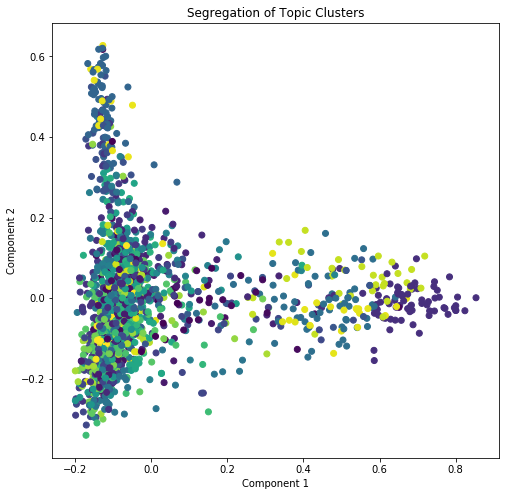

In [522]:
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=kmeans_data_norm['pred_label'])
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

# **Recommend similar Repos for a given one**

In [446]:
# Get the similarity matrix using Pearson Correlation
Pearson_simMatrix = 1 - pearson_dist(name_fit_norm)

In [391]:
def getSimRepo(repo, simMatrix, k):
    '''Return the top k most similar repos to the given one'''
    simMatrix = pd.DataFrame(simMatrix, index=tn_data['repo'], columns=tn_data['repo'])
    #repoid = tn_data[tn_data['repo'] == repo].index.tolist()[0]
    rec = list(simMatrix.loc[repo, :].sort_values(ascending=False)[1:k].index)
    return rec

In [529]:
getSimRepo('keon/algorithms', Pearson_simMatrix, 7)

['TheAlgorithms/Python',
 'django/django',
 'bitcoin/bitcoin',
 'tornadoweb/tornado',
 'Jahaja/psdash',
 'shawnwun/RNNLG']

In [573]:
getSimRepo('twitter/mysql', Pearson_simMatrix, 7)

['Tokutek/mysql-5.5',
 'Tokutek/mariadb-5.5',
 'facebook/mysql-5.6',
 'therecluse26/PHP-Login',
 'akopytov/sysbench',
 'sbabic/swupdate']

In [574]:
getSimRepo('torch/nn', Pearson_simMatrix, 7)

['pytorch/pytorch',
 'aciditeam/torch-models',
 'jcjohnson/neural-style',
 'keras-team/keras',
 'tensorflow/models',
 'fastai/fastai']

In [575]:
getSimRepo('WordPress/WordPress', Pearson_simMatrix, 7)

['markjaquith/WordPress',
 'jumilla/wordpress-plus',
 'dxw/wordpress',
 'mhoofman/wordpress-heroku',
 'owen2345/camaleon-cms',
 'twilio/OpenVBX']

## Including comments

In [532]:
com_data = sub_data[['repo']]
com_data['combine'] = sub_data['stemmed_name'] + sub_data['stemmed_comment']

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [379]:
buckets_length = []
for i in filter(is_prime, range(500, 1800, 29)):
    buckets_length.append(i)

In [266]:
sse = {}
for b_len in buckets_length:
    com_data['hash2vec'] = com_data['combine'].apply(lambda x: hash2vec(x, b_len))
    print("Hashing finished...")
    com_fit = vectorize(com_data['hash2vec'])
    com_fit_norm = normalize(com_fit, axis=1, norm='l2')
    print('vectorization finished...')
    sse_b = {}
    key = 'bucket' + str(b_len)
    for k in range(100, 400, 40):
        kmeans = KMeans(n_clusters=k, random_state=122, max_iter=200).fit(com_fit_norm)
        #data["clusters"] = kmeans.labels_
        #print(data["clusters"])
        sse_b[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
        print("Finished calculating k = " + str(k) + " for bucket length = " + str(b_len))
    sse[key] = sse_b

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 587
Finished calculating k = 140 for bucket length = 587
Finished calculating k = 180 for bucket length = 587
Finished calculating k = 220 for bucket length = 587
Finished calculating k = 260 for bucket length = 587
Finished calculating k = 300 for bucket length = 587
Finished calculating k = 340 for bucket length = 587
Finished calculating k = 380 for bucket length = 587


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 761
Finished calculating k = 140 for bucket length = 761
Finished calculating k = 180 for bucket length = 761
Finished calculating k = 220 for bucket length = 761
Finished calculating k = 260 for bucket length = 761
Finished calculating k = 300 for bucket length = 761
Finished calculating k = 340 for bucket length = 761
Finished calculating k = 380 for bucket length = 761


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 877
Finished calculating k = 140 for bucket length = 877
Finished calculating k = 180 for bucket length = 877
Finished calculating k = 220 for bucket length = 877
Finished calculating k = 260 for bucket length = 877
Finished calculating k = 300 for bucket length = 877
Finished calculating k = 340 for bucket length = 877
Finished calculating k = 380 for bucket length = 877


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 1051
Finished calculating k = 140 for bucket length = 1051
Finished calculating k = 180 for bucket length = 1051
Finished calculating k = 220 for bucket length = 1051
Finished calculating k = 260 for bucket length = 1051
Finished calculating k = 300 for bucket length = 1051
Finished calculating k = 340 for bucket length = 1051
Finished calculating k = 380 for bucket length = 1051


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 1109
Finished calculating k = 140 for bucket length = 1109
Finished calculating k = 180 for bucket length = 1109
Finished calculating k = 220 for bucket length = 1109
Finished calculating k = 260 for bucket length = 1109
Finished calculating k = 300 for bucket length = 1109
Finished calculating k = 340 for bucket length = 1109
Finished calculating k = 380 for bucket length = 1109


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 1283
Finished calculating k = 140 for bucket length = 1283
Finished calculating k = 180 for bucket length = 1283
Finished calculating k = 220 for bucket length = 1283
Finished calculating k = 260 for bucket length = 1283
Finished calculating k = 300 for bucket length = 1283
Finished calculating k = 340 for bucket length = 1283
Finished calculating k = 380 for bucket length = 1283


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 1399
Finished calculating k = 140 for bucket length = 1399
Finished calculating k = 180 for bucket length = 1399
Finished calculating k = 220 for bucket length = 1399
Finished calculating k = 260 for bucket length = 1399
Finished calculating k = 300 for bucket length = 1399
Finished calculating k = 340 for bucket length = 1399
Finished calculating k = 380 for bucket length = 1399


/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Hashing finished...
vectorization finished...
Finished calculating k = 100 for bucket length = 1747
Finished calculating k = 140 for bucket length = 1747
Finished calculating k = 180 for bucket length = 1747
Finished calculating k = 220 for bucket length = 1747
Finished calculating k = 260 for bucket length = 1747
Finished calculating k = 300 for bucket length = 1747
Finished calculating k = 340 for bucket length = 1747
Finished calculating k = 380 for bucket length = 1747


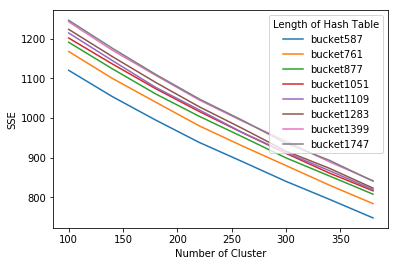

In [267]:
plt.figure()
n_cluster = [i for i in range(100, 400, 40)]
for n_bucket, record in sse.items():
    plt.plot(n_cluster, list(record.values()), label=str(n_bucket))
plt.xlabel("Number of Cluster")
plt.ylabel("SSE")
plt.legend(title='Length of Hash Table', loc='best')
plt.show()

In [533]:
com_data['hash2vec'] = com_data['combine'].apply(lambda x: hash2vec(x, 587))
com_fit = vectorize(com_data['hash2vec'])
com_fit_norm = normalize(com_fit, axis=1, norm='l2')

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## HAC

In [381]:
Z_com_norm = linkage(com_fit_norm, metric = 'correlation')

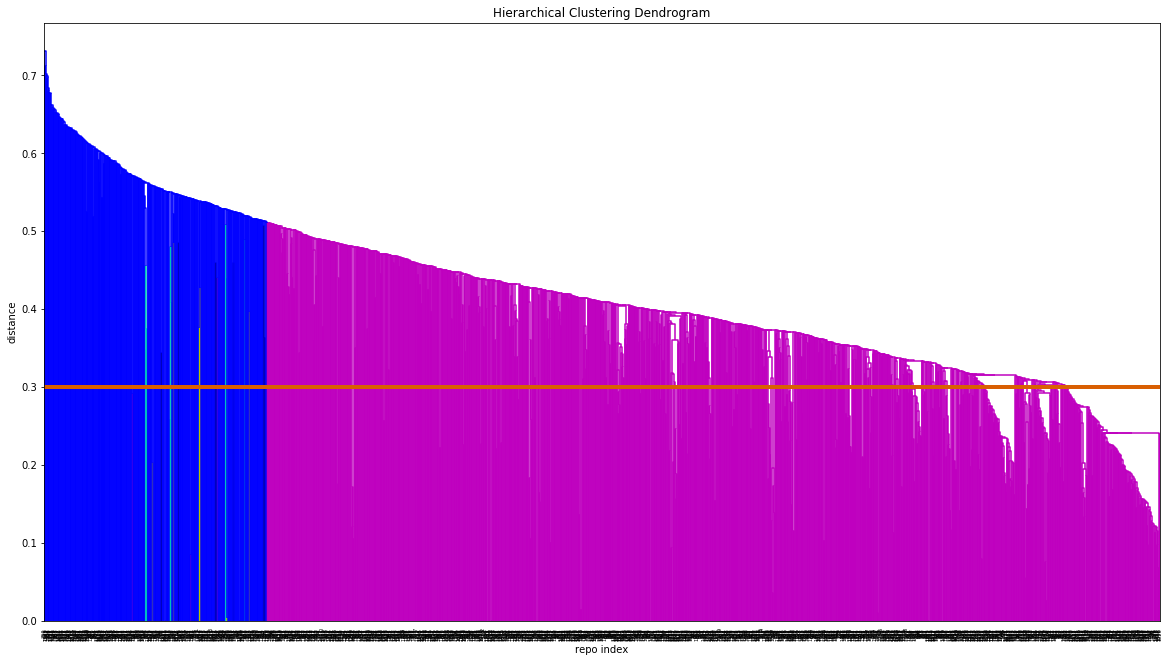

In [387]:
scipy.cluster.hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
plt.figure(figsize=(20, 11))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('repo index')
plt.ylabel('distance')

dendrogram(
    Z_com_norm,
    #truncate_mode='lastp',
   # leaf_font_size=10.,  # font size for the x axis labels
   # labels=,
    show_contracted=True,
    orientation='top'
   # above_threshold_color='y'
)
plt.axhline(y=.3, xmin=0, xmax=4, linewidth=4, color = '#d95f02')
#plt.axhline()
plt.show()

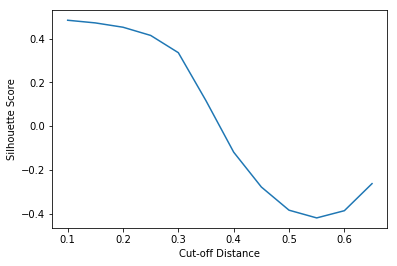

In [285]:
cut_off = [i for i in np.arange(0.1, 0.7, 0.05)]
silhouette = {}
dm = pearson_dist(com_fit_norm)
for co in cut_off:
    nodes = fcluster(Z_com_norm, co, criterion='distance')
    silhouette[co] = silhouette_score(dm, nodes, metric='correlation')
plt.figure()
plt.plot(list(silhouette.keys()), list(silhouette.values()))
plt.xlabel("Cut-off Distance")
plt.ylabel("Silhouette Score")
plt.show()

In [383]:
hac_com_data_norm = com_data
hac_com_data_norm['pred_label'] = fcluster(Z_com_norm, 0.5, criterion='distance')
test_hac_norm = hac_com_data_norm[hac_com_data_norm['repo'].isin(eval_table['repo'])]
len(set(hac_com_data_norm['pred_label']))

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


367

In [384]:
eval_com_ac_norm = eval_table[['repo', 'label']].merge(test_hac_norm[['repo', 'pred_label']], on='repo').drop_duplicates()
h_score = homogeneity_score(eval_com_ac_norm['label'], eval_com_ac_norm['pred_label'])
completeness = completeness_score(eval_com_ac_norm['label'], eval_com_ac_norm['pred_label'])
print("Homogeneity: %0.3f" % h_score)
print("Completeness: %0.3f" % completeness)
Recall = []
Precision = []
for name, group in eval_com_ac_norm.groupby('label'):
    if group.shape[0] > 1:
        purity = Counter(group['pred_label']).most_common()[0][1]
        recall = purity / group.shape[0]
        Recall.append(recall)
print('Recall is %.2f' %(sum(Recall)/len(Recall)))
for name, group in eval_com_ac_norm.groupby('pred_label'):
    if group.shape[0] > 1:
        purity = Counter(group['label']).most_common()[0][1]
        precision = purity / group.shape[0]
        Precision.append(precision)
print('Precision is %.2f' %(sum(Precision)/len(Precision)))
      


Homogeneity: 0.161
Completeness: 0.511
Recall is 0.95
Precision is 0.50


In [536]:
kmeans_com_data_norm = com_data
kmeans_norm = KMeans(n_clusters=150, random_state=122).fit(com_fit)
kmeans_com_data_norm['pred_label'] = kmeans_norm.labels_
kmeans_test_norm = kmeans_com_data_norm[kmeans_com_data_norm['repo'].isin(eval_table['repo'])]

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [537]:
eval_com_kmeans_norm = eval_table[['repo', 'label']].merge(kmeans_test_norm[['repo', 'pred_label']], on='repo').drop_duplicates()
h_score = homogeneity_score(eval_com_kmeans_norm['label'], eval_com_kmeans_norm['pred_label'])
completeness = completeness_score(eval_com_kmeans_norm['label'], eval_com_kmeans_norm['pred_label'])
print("Homogeneity: %0.3f" % h_score)
print("Completeness: %0.3f" % completeness)
Recall = []
Precision = []
for name, group in eval_com_kmeans_norm.groupby('label'):
    if group.shape[0] > 1:
        purity = Counter(group['pred_label']).most_common()[0][1]
        recall = purity / group.shape[0]
        Recall.append(recall)
print('Recall is %.2f' %(sum(Recall)/len(Recall)))
for name, group in eval_com_kmeans_norm.groupby('pred_label'):
    if group.shape[0] > 1:
        purity = Counter(group['label']).most_common()[0][1]
        precision = purity / group.shape[0]
        Precision.append(precision)
print('Precision is %.2f' %(sum(Precision)/len(Precision)))
      

Homogeneity: 0.510
Completeness: 0.754
Recall is 0.44
Precision is 0.45


In [390]:
cosine_simMatrix = 1 - cosine_similarity(com_fit_norm)
getSimRepo('nfl/react-helmet', Pearson_simMatrix, 7)

['riot/riot',
 'infernojs/inferno',
 'vuejs/vue',
 'jsdoc3/jsdoc',
 'yogthos/Selmer',
 'Meituan-Dianping/mpvue']